
0: 480x640 2 container_codes, 2 gross_weights, 1 tare_weight, 69.8ms
Speed: 2.5ms preprocess, 69.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


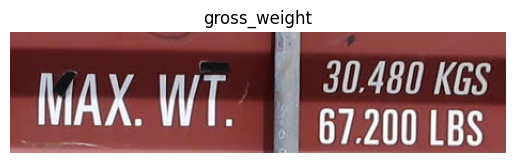

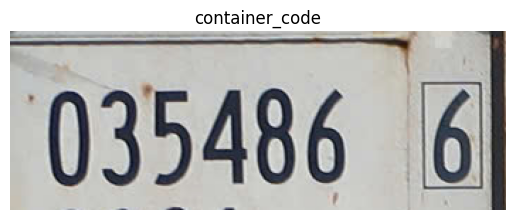

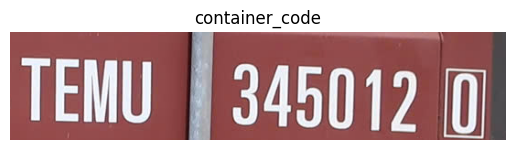

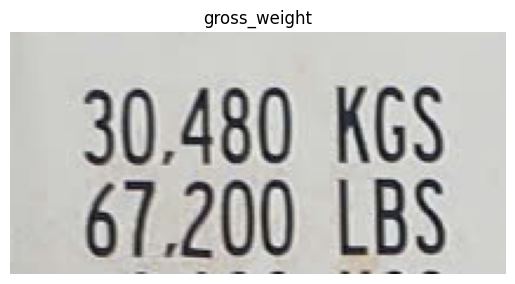

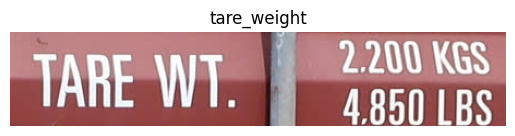

🎯 Kết quả trích xuất (enhanced):
{
  "gross_weight": "",
  "container_code": "Te | ea",
  "tare_weight": ""
}


In [1]:

from ultralytics import YOLO
import cv2
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

# Load YOLO model đã huấn luyện
model = YOLO('/Users/tenaity/Documents/MSE/asignment/yolo_runs/container-code-detector-v1/weights/best.pt')

# Load ảnh test container
image_path = '/Users/tenaity/Documents/MSE/asignment/test.jpg'  # ← Đổi ảnh thật tại đây
image = cv2.imread(image_path)

# Detect đối tượng
results = model(image)

# Lấy bounding boxes và classes
boxes = results[0].boxes.xyxy.cpu().numpy()
classes = results[0].boxes.cls.cpu().numpy()

# Danh sách tên class
class_names = ['container_code', 'gross_weight', 'tare_weight']

output = {}

# Hàm enhance ảnh
def enhance_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize lớn lên 2x để OCR chính xác hơn
    enlarged = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    # Sharpen
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(enlarged, -1, kernel)
    # Adaptive threshold
    threshed = cv2.adaptiveThreshold(sharpened, 255,
                                     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    return threshed

# Xử lý từng vùng crop
for i, box in enumerate(boxes):
    cls_id = int(classes[i])
    label = class_names[cls_id]

    x1, y1, x2, y2 = box.astype(int)
    cropped = image[y1:y2, x1:x2]

    # Hiển thị vùng crop
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f"{label}")
    plt.axis("off")
    plt.show()

    # Enhance và OCR
    enhanced = enhance_image(cropped)
    text = pytesseract.image_to_string(enhanced, config='--oem 3 --psm 7').strip()
    output[label] = text

# In kết quả
print("🎯 Kết quả trích xuất (enhanced):")
print(json.dumps(output, indent=2, ensure_ascii=False))
